# Applying our methods to CERN ghost track data

### Imports

In [12]:
#%pip install matplotlib numpy qiskit scipy pandas qiskit_machine_learning natsort tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit import Aer, transpile

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit.library import StatePreparation

from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import qiskit_machine_learning.kernels
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_blobs

import scipy.io
import pandas as pd
from qiskit.providers.aer import AerError
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
algorithm_globals.random_seed = 0
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import DensityMatrix
from functools import reduce
from sympy import Matrix
from sympy import sqrt as special_sqrt
from qiskit import *
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import Operator

import os
from natsort import natsorted
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


## Loading data

Label 1 represents the inlier class (regular tracks), label -1 the outlier class (ghost tracks).

In [13]:
# load all json files in cern_data folder
full_cern_data = []
for file in natsorted(os.listdir('cern_data')):
    if file.endswith('.json'):
        df = pd.read_json('cern_data/' + file)
        full_cern_data.append(df)

full_cern_data = pd.concat(full_cern_data, ignore_index=True)
# replace 1 (ghost) with -1 (outlier) and 0 (regular) with 1 (inlier)
full_cern_data['is_ghost'] = full_cern_data['is_ghost'].replace(1, -1).replace(0, 1)
full_cern_data

,chi2,is_ghost,kalman_ip_chi2,nb_hits,ndof,qop,tx,ty,x,y,z
0,37.042889,1,2.744781,29,22,0.000093,-0.032356,-0.026533,0.032351,-0.039451,2.051071
1,12.333838,1,505.177429,21,6,-0.000100,-0.020835,-0.022025,-1.026810,0.971350,124.333954
2,11.791684,1,1.248908,24,12,0.000113,-0.008289,-0.035582,-0.032666,0.007609,84.878311
3,22.339798,1,3893.681641,26,16,-0.000053,-0.004296,-0.019615,0.003717,-0.000814,-109.656128
4,19.041876,1,2.024810,25,14,0.000094,-0.007948,-0.046065,0.069844,-0.012051,84.299057
...,...,...,...,...,...,...,...,...,...,...,...
18320,21.877516,1,1.353087,31,26,-0.000246,-0.003892,0.094137,-0.010576,-0.000436,-133.640045
18321,17.455692,1,0.945140,22,8,-0.000223,-0.170432,-0.096830,0.027389,-0.048208,94.859215
18322,2.377720,1,1.130440,20,6,-0.000157,-0.092891,-0.061437,0.007144,-0.010802,94.624451
18323,7.393714,1,10.609664,26,18,-0.000206,0.122870,-0.017398,0.016633,0.117464,-32.473801


In [14]:
full_cern_data['is_ghost'].value_counts()

 1    17705
-1      620
Name: is_ghost, dtype: int64

In [15]:
full_cern_data[full_cern_data['is_ghost'] == -1]

,chi2,is_ghost,kalman_ip_chi2,nb_hits,ndof,qop,tx,ty,x,y,z
114,6.736708,-1,2.013437,17,4,-0.000317,0.156288,-0.067397,0.011041,0.025599,196.992310
122,10.666078,-1,0.258542,21,8,-0.000028,-0.020742,-0.000281,-0.000607,0.044702,9.808350
123,91.954224,-1,41.465874,21,8,-0.000029,-0.020258,-0.000281,-0.000660,0.047713,-1.533783
124,7.582039,-1,1.203741,21,8,-0.000029,-0.019606,-0.000397,-0.000422,0.020831,9.954773
146,23.850941,-1,0.210660,29,24,0.000157,-0.034494,0.020627,-0.011212,-0.018750,-30.769402
...,...,...,...,...,...,...,...,...,...,...,...
18081,14.100121,-1,6.466623,26,18,-0.000182,0.086158,-0.034164,0.022217,0.056031,-27.052513
18150,210.464294,-1,7.795339,24,14,-0.000118,0.018131,0.093354,-0.075147,0.014596,-13.119804
18261,4.791725,-1,4.774308,17,4,0.000014,-0.001622,0.015018,-0.071725,-0.007744,109.908081
18263,15.251548,-1,0.920522,24,12,0.000086,-0.016061,0.033375,-0.023291,-0.011209,116.459412


### Feature selection

See the [CERN Data Guide](https://docs.google.com/document/d/1EQr-oIjMbOGgLth4iChvGo2jRGnEAutgjDI_1fn2nag/edit#) for explanations of the variables and why we select the ones we do.

In [16]:
# create new column for a normalized chi squared measure
full_cern_data['chi2/dof'] = full_cern_data['chi2']/full_cern_data['ndof']

# select most important features as explained in the Data Guide
cern_data = full_cern_data[['chi2/dof', 'kalman_ip_chi2', 'nb_hits', 'is_ghost']]
cern_data

,chi2/dof,kalman_ip_chi2,nb_hits,is_ghost
0,1.683768,2.744781,29,1
1,2.055640,505.177429,21,1
2,0.982640,1.248908,24,1
3,1.396237,3893.681641,26,1
4,1.360134,2.024810,25,1
...,...,...,...,...
18320,0.841443,1.353087,31,1
18321,2.181962,0.945140,22,1
18322,0.396287,1.130440,20,1
18323,0.410762,10.609664,26,1


### Preprocessing

Standardize features (subtract mean and scale to unit variance)

In [8]:
std_cern_data = StandardScaler().fit_transform(cern_data.drop(columns=['is_ghost']))
std_cern_data = pd.DataFrame(std_cern_data, columns=cern_data.drop(columns=['is_ghost']).columns)
std_cern_data['is_ghost'] = cern_data['is_ghost']
std_cern_data

,chi2/dof,kalman_ip_chi2,nb_hits,is_ghost
0,0.041073,-0.190888,1.238320,1
1,0.117441,0.143397,-1.279191,1
2,-0.102912,-0.191883,-0.335124,1
3,-0.017975,2.397880,0.294253,1
4,-0.025389,-0.191367,-0.020435,1
...,...,...,...,...
18320,-0.131908,-0.191813,1.867697,1
18321,0.143383,-0.192085,-0.964502,1
18322,-0.223326,-0.191962,-1.593879,1
18323,-0.220353,-0.185655,0.294253,1


## Custom Feature Maps

In [9]:
def custom_data_map_func(x):
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return mapped
def feature_map_superfidel(x):
    # as described in 
    # https://doi.org/10.1103/PhysRevA.97.042315
    
    # Qiskit currently doesn't natively support a square root function in a parameter expression
    # So use sympy base to get the same effect
    mapped = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, 
                                             np.divide(x,(1-np.square(np.column_stack(x)).trace())._call(special_sqrt)))
    return mapped

## Quantum Function for OneClass (Algorithm 1)

In [10]:
# First algorithm, returns trained model
def Algorithm1(X, y, reps=2, shots=1, outlier_fraction=20/210,
               entanglement="linear", num_features = 2, seed = 0, 
               supervised=False, feature_map_no = 1, data_map_no = 1,
               svm_max_iter=-1) :
    if feature_map_no == 1:
        # Define ZZFeatureMap using inputs
        if data_map_no == 1:
             feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement)
        elif data_map_no == 2:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = custom_data_map_func)
        elif data_map_no == 3:
            feature_map = ZZFeatureMap(feature_dimension = num_features, 
                                   reps = reps, entanglement=entanglement, 
                                       data_map_func = feature_map_superfidel)
    elif feature_map_no == 2:
        # Define ZZFeatureMap using inputs
        feature_map = ZFeatureMap(feature_dimension = num_features, reps = reps)
    elif feature_map_no == 3:
        # Define ZZFeatureMap using inputs
        feature_map = PauliFeatureMap(feature_dimension = num_features, reps = reps)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    # Kernel needs to be evaluated before going into the One-Class SVM
    svm = OneClassSVM(kernel = kernel.evaluate, verbose=True, nu=outlier_fraction, max_iter=svm_max_iter)
    if supervised: 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        # TODO save to Matrix
#         print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))

        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
#         print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))

#         print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#         print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))
    else: 
        svm.fit(X)

        # Predict step moved
#         y_pred = svm.predict(X)
#         #TODO save to matrix
# #         print(classification_report(y, y_pred))
#         print("Accuracy: {}".format(accuracy_score(y, y_pred)))

#         print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
#         print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
        
#         print("Macro Recall: {}".format(recall_score(y, y_pred, average='macro')))
#         print("Macro F1: {}".format(f1_score(y, y_pred, average='macro')))

#         print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#         print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))

#         print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#         print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

    return svm

## Sample training data

In [75]:
num_samples = 1000#len(std_cern_data)

cern_sample = std_cern_data.sample(num_samples, random_state=0)

# select input features
X = cern_sample.drop(columns=['is_ghost']) 
y = cern_sample['is_ghost']

outlier_counts = y.value_counts()
outlier_fraction = outlier_counts[-1]/outlier_counts[1]
print('Outlier fraction:', outlier_fraction)
print(outlier_counts)

Outlier fraction: 0.03734439834024896
 1    964
-1     36
Name: is_ghost, dtype: int64


## Applying Algorithm 1 to data

### Training

In the LibSVM verbose output
* `obj` refers to the optimal value of the objective function reached at convergence of the dual SVM problem (lower bound to the optimal value of the primal problem). (Dual: The objective function is minimized. Primal: The objective function is maximized.)
* `rho` relates to the size of the margins at convergence and is the bias term in the decision function.
* `nSV` and `nBSV` are number of support vectors and bounded support vectors

In [44]:
trained_svm = Algorithm1(X, y, reps=1, num_features=3, svm_max_iter=-1, outlier_fraction=outlier_fraction)

[LibSVM]*.
*
optimization finished, #iter = 1564
obj = 87.163041, rho = 4.668149
nSV = 109, nBSV = 7


**Record of Runtimes:**

(including inference)  
*num_samples, svm_max_iter, runtime, macroF1*  
100, 2, 13s  
100, 10, 21s  
100, 258(-1), 16s, 0.46  

200, 1, 1m3s, 0.24  
200, 240(-1), 1m3s, 0.57  

300, 493(-1), 2m28s, 0.53

(exluding inference)  
300, 250, 1m11  
1000, 1564, 24min40s  

```
Warning: using -h 0 may be faster
*
optimization finished, #iter = 1564
obj = 87.163041, rho = 4.668149
nSV = 109, nBSV = 7
```

### Inference

In [78]:
cern_test_sample = std_cern_data.sample(100, random_state=1)

# select input features
X_test = cern_test_sample.drop(columns=['is_ghost']) 
y_test = cern_test_sample['is_ghost']

print(y_test.value_counts())

y_pred = trained_svm.predict(X_test)

print("Macro F1: {}".format(f1_score(y_test, y_pred, average='macro')))


 1    97
-1     3
Name: is_ghost, dtype: int64


NameError: name 'trained_svm' is not defined

**Record of inference runtimes:**  
100 (trained on 300), 50s, 0.47F1  
100 (trained on 300), 50s, 0.51F1  
100 (trained on 1000), 3m7s, 0.4945F1

## Comparison to classical one-class SVM methods

In [84]:
kernel_list = ['rbf', 'linear', 'poly', 'sigmoid']
supervised = False

classical_results = []

for kernel in kernel_list:
    svm_classical = OneClassSVM(kernel = kernel, verbose=True,  nu=outlier_fraction)
    print("{}:\n".format(kernel))

    if supervised:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
        svm_classical.fit(X_train, y_train)
        y_pred = svm_classical.predict(X_test)
        # TODO save to Matrix
        print("{}: ".format(kernel))
#             print(classification_report(y_test, y_pred))
        print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
        
        print("Precision 1: {}".format(precision_score(y_test, y_pred, average='binary')))
        print("Precision -1: {}".format(precision_score(y_test, y_pred, pos_label=-1, average='binary')))
        
        print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        print("F1 1: {}".format(f1_score(y, y_pred, average='macro')))
        
#             print("Recall 1: {}".format(recall_score(y_test, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y_test, y_pred, pos_label=-1, average='binary')))
        
#             print("F1 1: {}".format(f1_score(y_test, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y_test, y_pred, pos_label=-1, average='binary')))

    else:
        svm_classical.fit(X)
        y_pred = svm_classical.predict(X_test)
        # TODO save to Matrix
        
#             print(classification_report(y, y_pred))
        # print("Accuracy: {}".format(accuracy_score(y, y_pred)))
        
        # print("Precision 1: {}".format(precision_score(y, y_pred, average='binary')))
        # print("Precision -1: {}".format(precision_score(y, y_pred, pos_label=-1, average='binary')))
        
        # print("Recall 1: {}".format(recall_score(y, y_pred, average='macro')))
        f1 = f1_score(y_test, y_pred, average='macro')
        classical_results.append(f1)
        print("Macro F1: {}".format(f1))
#             print("Recall 1: {}".format(recall_score(y, y_pred, average='binary')))
#             print("Recall -1: {}".format(recall_score(y, y_pred, pos_label=-1, average='binary')))
        
#             print("F1 1: {}".format(f1_score(y, y_pred, average='binary')))
#             print("F1 -1: {}".format(f1_score(y, y_pred, pos_label=-1, average='binary')))

    print('---------------------------\n')

rbf:

[LibSVM]*
optimization finished, #iter = 89
obj = 65.388535, rho = 4.007559
nSV = 46, nBSV = 31
Macro F1: 0.4845360824742268
---------------------------

linear:

[LibSVM]*
optimization finished, #iter = 12
obj = -0.000001, rho = -0.000022
nSV = 43, nBSV = 34
Macro F1: 0.4897959183673469
---------------------------

poly:

[LibSVM]*......
*
optimization finished, #iter = 6924
obj = 0.001300, rho = 0.000295
nSV = 55, nBSV = 29
Macro F1: 0.2145514675485738
---------------------------

sigmoid:

[LibSVM]*
optimization finished, #iter = 57
obj = -129.543514, rho = -6.198608
nSV = 38, nBSV = 36
Macro F1: 0.49238578680203043
---------------------------



# Plotting results

Macro F1 results when running classical training and testing on same sets as quantum training and testing:

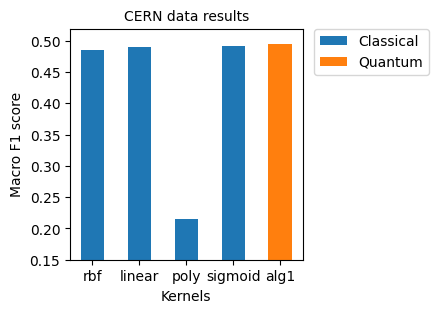

In [106]:
#classical_results = [0.4845, 0.4897, 0.2145, 0.4923]

plt.figure(figsize=(3, 3))

# bars for classical:
plt.bar(kernel_list, classical_results, label='Classical', width=0.5)

# bars for quantum:
plt.bar(['alg1'], [0.4945], label='Quantum', width=0.5)

plt.ylim(0.15)
plt.xlabel('Kernels')
plt.ylabel('Macro F1 score')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
# Title added in latex
#plt.title('CERN data results \n Trained with 1000 samples, tested on 100 samples')
plt.title('CERN data results', fontsize=10)
plt.show()

Macro F1 results when running classical on the full CERN data and testing on the full CERN data:

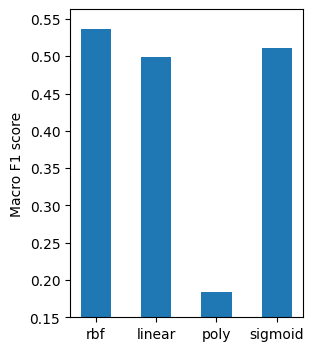

In [73]:
classical_full_results = [0.5362, 0.4984, 0.1840, 0.5108]
#x_pos = [1/4, 2/4, 3/4, 4/4]

plt.figure(figsize=(3, 4))
plt.bar(kernel_list, classical_full_results, label='Classical', width=0.5)
plt.ylim(0.15)
plt.ylabel('Macro F1 score')
#plt.xticks(x_pos, kernel_list)
plt.show()

# Appendix: Assessing the quality of other features

This would be due-diligence that can be done if there is still time.

In [17]:
full_cern_data

,chi2,is_ghost,kalman_ip_chi2,nb_hits,ndof,qop,tx,ty,x,y,z,chi2/dof
0,37.042889,1,2.744781,29,22,0.000093,-0.032356,-0.026533,0.032351,-0.039451,2.051071,1.683768
1,12.333838,1,505.177429,21,6,-0.000100,-0.020835,-0.022025,-1.026810,0.971350,124.333954,2.055640
2,11.791684,1,1.248908,24,12,0.000113,-0.008289,-0.035582,-0.032666,0.007609,84.878311,0.982640
3,22.339798,1,3893.681641,26,16,-0.000053,-0.004296,-0.019615,0.003717,-0.000814,-109.656128,1.396237
4,19.041876,1,2.024810,25,14,0.000094,-0.007948,-0.046065,0.069844,-0.012051,84.299057,1.360134
...,...,...,...,...,...,...,...,...,...,...,...,...
18320,21.877516,1,1.353087,31,26,-0.000246,-0.003892,0.094137,-0.010576,-0.000436,-133.640045,0.841443
18321,17.455692,1,0.945140,22,8,-0.000223,-0.170432,-0.096830,0.027389,-0.048208,94.859215,2.181962
18322,2.377720,1,1.130440,20,6,-0.000157,-0.092891,-0.061437,0.007144,-0.010802,94.624451,0.396287
18323,7.393714,1,10.609664,26,18,-0.000206,0.122870,-0.017398,0.016633,0.117464,-32.473801,0.410762
